In [1]:
%run -i namespace.py

# Example: Process streaming data

Here, we show an example to process the streaming data. The streaming data is obtained from the database and we will use `databroker` as the interface to the database. In real use cases, the data will be from the `RunEngine`.

## Take a look at the raw data

First, we take a look at what our data is like. This is a grid scan on a crystal rod. At each pixel in the grid, there are multiple frames of diffraction images.

In [16]:
uid = UID["uid"][0]
run = DB[uid]

In [4]:
dask_array = run.xarray_dask()
dask_array.attrs = dict(run.start)

Here, we plot the spatial distribution of the total intensity. The upper part of the rod is made up by multiple crystalline domains while the lower part is full of powder.

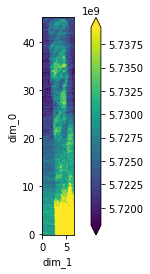

In [6]:
stats1 = reshape(dask_array, "dexela_stats1_total")
plot_real_aspect(stats1);

We select a image taken at the empty space. The image only contains dark current and air scattering. We will use this to subtract all other images in this scan.

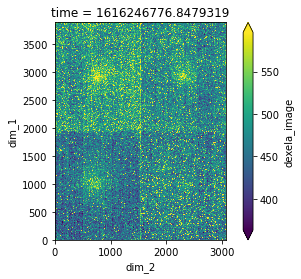

In [7]:
image = dask_array["dexela_image"][4523].compute().mean(axis=0)
plot_real_aspect(image);

## Use callbacks to process the event stream

Here, we use the callbacks to process the data in a stream. The frames will be first go into the `ImageProcessor`. The frames will be averaged and subtracted by the `subtrahend`. Because diffraction image is non-negative, the negative pixels will be filled with zero. Then, the results will be sent to `PeakTracker`. It will find the Bragg peaks on the images and output each peak as a single event. The data will be dumped to `DB2`. During this process, `TrackLinker` will monitor the events. If all peaks have been found in all images, it will start linking the peaks and output where the same Bragg peak is on a series of images. The results will also be recorded in the database.

The argument `dexela_image` is the name of the data key of the data in the event stream. `diameter=15, percentile=80, separation=100` are the key words for the `trackpy.locate`. `search_range=50` is the key word for the `trackpy.link`. Please see the documents of [trackpy](http://soft-matter.github.io/trackpy/v0.5.0/api.html) for more information.

Here, the `BestEffortCallback` is used to print out the status of `ImageProcessor`. It is optional and does nothing to the data.

In [4]:
ip = ImageProcessor("dexela_image", subtrahend=image)
pt = PeakTracker("dexela_image", diameter=15, percentile=80, separation=100)
tl = TrackLinker(db=DB2, search_range=50)
bec = BestEffortCallback()
bec.disable_plots()
tl.subscribe(DB2.insert)
pt.subscribe(tl)
pt.subscribe(DB2.insert)
ip.subscribe(pt)
ip.subscribe(bec);

We pipe the data from our database to this callback function.

In [ ]:
with Filler(
    handler_registry=dict(DB.reg.handler_reg), 
    inplace=True, 
    root_map=DB.reg.root_map
) as filler:
    for name, doc in run.documents(fill=False):
        filler(name, doc)
        ip(name, doc)

## Use servers to process the real time event stream

We are basically replaying the data processing procedure in the last section. In this section, we will learn how the data is processed at the beamline in "real time". We need to setup a server that wraps the callback function in last section. An example script is show here.

In [7]:
!cat server.py

import numpy as np
from databroker import Broker
from bluesky.callbacks.best_effort import BestEffortCallback
from tomography.callbacks import ImageProcessor, PeakTrackor, TrackLinker
from bluesky.callbacks.zmq import RemoteDispatcher

# load the image to use
image = np.load("./data/PARAMID-2_background_1.npy", allow_pickle=True)

# create a remote dispatcher to receive the dispatch the data
rd = RemoteDispatcher(address=("localhost", 5568), prefix=b'raw')

# create the callback
ip = ImageProcessor("dexela_image", subtrahend=image)
pt = PeakTracker("dexela_image", diameter=15, percentile=80, separation=100)
tl = TrackLinker(db=DB2, search_range=50)
bec = BestEffortCallback()
bec.disable_plots()
tl.subscribe(DB2.insert)
pt.subscribe(tl)
pt.subscribe(DB2.insert)
ip.subscribe(pt)
ip.subscribe(bec)

# subscribe the callback to the dispatcher
rd.subscribe(ip)

# start the server
if __name__ == "__main__":
    print("Start the server ...")
    rd.start()


To start the server, we will run::

    python server.py


Then, this server will receive the data from "localhost:5568" with prefix "raw" and process the data using the callback defined in the script.

## Pipe the data into the database

We can also publish the data in the database to the server using `Publisher`. Here, we show an example to publish our data to "localhost:5567". The server will process the data just like it is from the beamline devices.

In [ ]:
pub = Publisher("localhost", 5567)
with Filler(
    handler_registry=dict(DB.reg.handler_reg), 
    inplace=True, 
    root_map=DB.reg.root_map
) as filler:
    for name, doc in run.documents(fill=False):
        filler(name, doc)
        pub(name, doc)